# What is BasicVSR?
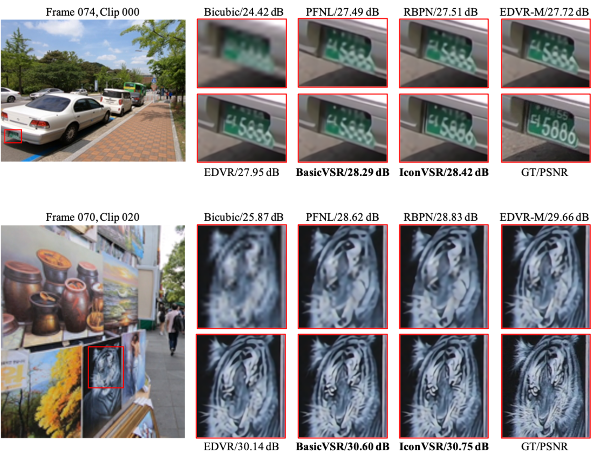

[BasicVSR](https://arxiv.org/abs/2012.02181) stands for Basic Video Super-Resolution which means it is designed to upscale input videos up to 4x. The network is named "basic" as it was designed to be as simple as possible, which allows it to be used as a base model to improve upon with future papers. See [BasicVSR++](https://arxiv.org/abs/2104.13371) for an improved implementation of BasicVSR. In this notebook, we will train BasicVSR to upsample videos 4x.

### Imports

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from PIL import Image
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os, glob, multiprocessing, torch

### Hyperparameters

In [2]:
BATCH_SIZE = 12
EPOCHS = 50
SHOW_PREDS_EVERY = 10 # every 10 epochs, display the model predictions
N_CORES = multiprocessing.cpu_count()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset
I used the REDS (REalistic and Dynamic Scenes) dataset which was used in the BasicVSR paper and can be downloaded at https://seungjunnah.github.io/Datasets/reds.
Since I just wanted to see how well BasicVSR could function, I downloaded the low-res dataset (320x180 px), resized the images to 228x128 px, then took a central crop to obtain 128x128 px images which I treated as the HR (high-resolution) images. I then downscaled these 128x128 px images 4x for my LR (low-resolution) images, which are 32x32 px.

This PyTorch dataset grabs a certain amount of consecutive frames from the HR and LR videos (the paper did 15 frames, so I did the same).

In [3]:
ds_path = '../input/reds-video-superresolution-toy-dataset'
class VSRDataset(Dataset):
    def __init__(self, lr_path=f'{ds_path}/lr', hr_path=f'{ds_path}/hr', imgs_per_clip=15):
        '''
        Args:
        lr_path (str): Represents a path that contains a set of folders,
            where each folder contains a sequence of
            consecutive LR frames of a video.
        hr_path (str): See lr_path, but each folder
            contains HR frames. The folder and image names,
            when sorted, should be a 1:1 match with the LR frames
            (i.e. the third image in the second folder of the lr_path
            should be the LR image ofthe third image
            in the second folder of the hr_path).
        imgs_per_clip (int): The number of images that
            represents an input video. Default is 15,
            meaning each input video will consist of
            15 consecutive frames.
        '''
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.imgs_per_clip = imgs_per_clip
        self.lr_folders = sorted(glob.glob(f'{self.lr_path}/*') )
        self.hr_folders = sorted(glob.glob(f'{self.hr_path}/*'))
        self.clips_per_folder = len(glob.glob(f'{self.lr_folders[0]}/*')) // imgs_per_clip
        self.num_clips = len(self.lr_folders) * self.clips_per_folder
    
    def __len__(self):
        return self.num_clips
    
    def __getitem__(self, idx):
        '''
        Returns a np.array of an input video that is of shape
        (T, H, W, 3), where T = imgs per clip, H/W = height/width,
        and 3 = channels (3 for RGB images). Note that the video
        pixel values will be between [0, 255], not [0, 1).
        '''
        folder_idx, clip_idx = idx // self.clips_per_folder, idx % self.clips_per_folder
        s_i, e_i = self.imgs_per_clip * clip_idx, self.imgs_per_clip * (clip_idx + 1)
        lr_fnames = sorted(glob.glob(f'{self.lr_folders[folder_idx]}/*'))[s_i:e_i]
        hr_fnames = sorted(glob.glob(f'{self.hr_folders[folder_idx]}/*'))[s_i:e_i]
        
        for i, (lr_fname, hr_fname) in enumerate(zip(lr_fnames, hr_fnames)):
            lr_img = np.array(Image.open(lr_fname))
            hr_img = np.array(Image.open(hr_fname))
            if i == 0: # instantiate return LR and HR arrays if loading the first image of the batch
                lr_res_y, lr_res_x, _c = lr_img.shape
                hr_res_y, hr_res_x, _c = hr_img.shape
                lr = np.zeros((self.imgs_per_clip, lr_res_y, lr_res_x, 3), dtype=np.uint8)
                hr = np.zeros((self.imgs_per_clip, hr_res_y, hr_res_x, 3), dtype=np.uint8)
            lr[i], hr[i] = lr_img, hr_img
        
        return lr, hr

In [4]:
ds = VSRDataset()
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_CORES)

### Visualize Dataset Outputs

LR shape: torch.Size([15, 32, 32, 3]) | HR Shape: torch.Size([15, 128, 128, 3]) | Dtype: torch.uint8


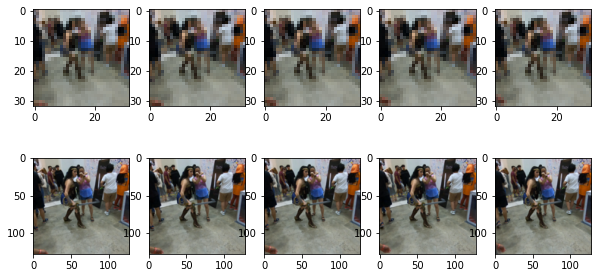

In [5]:
for lr, hr in dataloader:
    lr, hr = lr[0], hr[0]
    print(f'LR shape: {lr.shape} | HR Shape: {hr.shape} | Dtype: {lr.dtype}')
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    for i in range(5):
        ax[0][i].imshow(lr[i])
        ax[1][i].imshow(hr[i])
    plt.show()
    break

### Flow Warp Function
Since this network deals with video inputs which have moving objects, it is important to account for this motion while gathering information in order to upsample the objects within the video. The BasicVSR authors addressed this issue by using an optical flow network to estimate the motion between frames and use this predicted motion to align the features between the frames, which improved the quality in output.

This function below is the major alignment function, taking in an input tensor, a flow field, and some other parameters, and outputs the tensor whose pixels are warped from the flow field.

This code was taken from the MMEditing Git repo, specifically this file: https://github.com/open-mmlab/mmediting/blob/3351cdc398dc34813614e021269a92b4ad84da92/mmedit/models/common/flow_warp.py

In [6]:
def flow_warp(x,
              flow,
              interpolation='bilinear',
              padding_mode='zeros',
              align_corners=True):
    '''Warp an image or a feature map with optical flow.
    Args:
        x (Tensor): Tensor with size (n, c, h, w).
        flow (Tensor): Tensor with size (n, h, w, 2). The last dimension is
            a two-channel, denoting the width and height relative offsets.
            Note that the values are not normalized to [-1, 1].
        interpolation (str): Interpolation mode: 'nearest' or 'bilinear'.
            Default: 'bilinear'.
        padding_mode (str): Padding mode: 'zeros' or 'border' or 'reflection'.
            Default: 'zeros'.
        align_corners (bool): Whether align corners. Default: True.
    Returns:
        Tensor: Warped image or feature map.
    '''
    _N, _C, H, W = x.shape
    device = flow.device
    grid_y, grid_x = torch.meshgrid(
        torch.arange(0, H, device=device, dtype=x.dtype),
        torch.arange(0, W, device=device, dtype=x.dtype))
    grid = torch.stack((grid_x, grid_y), dim=2)
    grid_flow = flow.permute((0, 2, 3, 1)) + grid # flow shape: NCHW to NHWC
    
    # normalize grid flows to [-1, 1]
    grid_flow_x = 2.0 * grid_flow[:, :, :, 0] / max(W - 1, 1) - 1.0
    grid_flow_y = 2.0 * grid_flow[:, :, :, 1] / max(H - 1, 1) - 1.0
    grid_flow = torch.stack((grid_flow_x, grid_flow_y), dim=3)
    
    output = F.grid_sample(
        x,
        grid_flow,
        mode=interpolation,
        padding_mode=padding_mode,
        align_corners=align_corners)
    
    return output

### SpyNet (Optical Flow Network)
SpyNet takes two input images and calculates the optical flow between the two images. 

The input images are represented as (N, C, H, W) tensors where N=batch size, C=number of channels, H=image height, W=image width.
Optical flow is represented as an (N, 2, H, W) tensor where N=batch size, with 2 HxW feature maps representing the motion for each pixel in the x and y direction respectively.

Code taken from https://github.com/open-mmlab/mmediting/blob/a852622b837274ff845b385eb895d540bfe6981e/mmedit/models/backbones/sr_backbones/basicvsr_net.py

In [7]:
spynet_module = lambda: nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=7, stride=1, padding=3), nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=7, stride=1, padding=3)
            )  

class SPyNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.basic_module = nn.ModuleList(
            [spynet_module() for _ in range(6)])

        self.register_buffer(
            'mean',
            torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer(
            'std',
            torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def compute_flow(self, ref, supp): # ref = reference image, supp = supporting image
        N, _, H, W = ref.shape
        
        # normalize reference and supporting frames
        ref = [(ref - self.mean) / self.std]
        supp = [(supp - self.mean) / self.std]
        
        # generate downscaled images
        for _ in range(5):
            ref.append(F.avg_pool2d(ref[-1], kernel_size=2, stride=2))
            supp.append(F.avg_pool2d(supp[-1], kernel_size=2, stride=2))
        ref, supp = ref[::-1], supp[::-1]
        
        # compute and refine flows
        flow = ref[0].new_zeros(N, 2, H // 32, W // 32)
        for level in range(len(ref)):
            if level == 0:
                flow_up = flow
            else:
                flow_up = F.interpolate(flow, scale_factor=2, mode='bilinear', align_corners=True) * 2.0
                flow_residue = self.basic_module[level](
                    torch.cat([
                        ref[level],
                        flow_warp(supp[level], flow_up, padding_mode='border'),
                        flow_up
                    ], dim=1))
                
                # add the residue to the upsampled flow
                flow = flow_up + flow_residue
        
        return flow
    
    def forward(self, ref, supp): # upscale ref and supp to be processed, do the processing, rescale the flow to original resolution
        # upsize to a multiple of 32
        H, W = ref.shape[2:4]
        w_up = W if (W % 32) == 0 else 32 * (W // 32 + 1)
        h_up = H if (H % 32) == 0 else 32 * (H // 32 + 1)
        ref = F.interpolate(ref, size=(h_up, w_up), mode='bilinear', align_corners=False)
        supp = F.interpolate(supp, size=(h_up, w_up), mode='bilinear', align_corners=False)

        # compute flow, and resize back to the original resolution
        flow = F.interpolate(self.compute_flow(ref, supp), size=(H, W), mode='bilinear', align_corners=False)

        # adjust the flow values
        flow[:, 0, :, :] *= float(W) / float(w_up)
        flow[:, 1, :, :] *= float(H) / float(h_up)

        return flow

### Generator
The actual BasicVSR network. It consists of feature alignment (S=SpyNet, W=warp), residual (R), and upsampling (U) blocks and uses a bidirectional (gathers information from past frames as well as future frames) and recurrent (updates a hidden state representing the features of the entire input video with every image it sees) structure. The image below shows a high-level diagram of the network. 


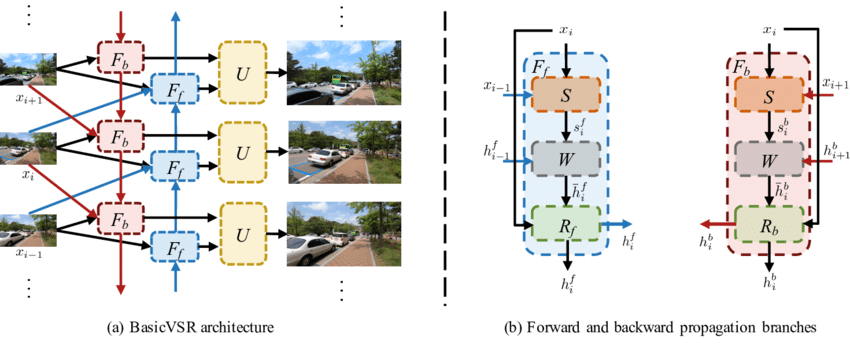


Code taken from https://github.com/open-mmlab/mmediting/blob/a852622b837274ff845b385eb895d540bfe6981e/mmedit/models/backbones/sr_backbones/basicvsr_net.py

In [8]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.conv1 = nn.Conv2d(nc, nc, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(nc, nc, 3, stride=1, padding=1)
    
    def forward(self, x):
        return x + self.conv2(F.relu(self.conv1(x)))

class Generator(nn.Module):
    def __init__(self, nblocks=30, nc=64):
        super().__init__()
        self.spynet = SPyNet()
        self.nblocks = nblocks
        self.nc = nc
        self.lrelu = nn.LeakyReLU(0.1)
        self.forward_res = nn.Sequential(nn.Conv2d(nc+3, nc, 3, stride=1, padding=1), self.lrelu, *[ResBlock(nc) for _ in range(nblocks)])
        self.backward_res = nn.Sequential(nn.Conv2d(nc+3, nc, 3, stride=1, padding=1), self.lrelu, *[ResBlock(nc) for _ in range(nblocks)])
        self.fusion = nn.Conv2d(2*nc, nc, 3, stride=1, padding=1)
        self.up_conv1 = nn.Conv2d(nc, 4*64, 3, stride=1, padding=1)
        self.up_conv2 = nn.Conv2d(nc, 4*64, 3, stride=1, padding=1)
        self.hr_conv = nn.Conv2d(64, 3, 3, stride=1, padding=1)
        
    def compute_flows(self, x):
        N, T, C, H, W = x.shape
        x_start = x[:, :-1, :, :, :].reshape(-1, C, H, W) # reshape from (N, T, C, H, W) into (N*T, C, H, W)
        x_end = x[:, 1:, :, :, :].reshape(-1, C, H, W)
        forward_flows = self.spynet(x_start, x_end).view(N, T-1, 2, H, W)
        backward_flows = self.spynet(x_end, x_start).view(N, T-1, 2, H, W)
        
        return forward_flows, backward_flows
    
    def forward(self, x):
        N, T, C, H, W = x.shape
        forward_flows, backward_flows = self.compute_flows(x) # flow estimation (S step)
        
        # backward propagation
        features = x.new_zeros((N, self.nc, H, W)) # initialize features as zeros with same dtype and device as x
        outputs = []
        for t in range(T-1, -1, -1):
            if t != T-1: # warp features if not looking at last frame of clip 
                features = flow_warp(features, backward_flows[:, t, :, :, :]) # feature warping (W step)
            features = torch.cat((features, x[:, t, :, :, :]), dim=1) # concatenate NCHW tensors along C axis
            features = self.backward_res(features) # residual processing (R step)
            outputs.append(features)
        outputs = outputs[::-1]
        
        # forward propagation
        features = x.new_zeros((N, self.nc, H, W)) # initialize features as zeros with same dtype and device as x
        for t in range(T):
            lr_curr = x[:, t, :, :, :]
            if t != 0: # warp features if not looking at first frame of clip 
                features = flow_warp(features, forward_flows[:, t-1, :, :, :]) # feature warping (W step)
            features = torch.cat((features, lr_curr), dim=1)
            features = self.forward_res(features) # residual processing (R step)
        
            # fuse forward and backward features, then upsample
            bidirectional_features = torch.cat((features, outputs[t]), dim=1)
            fused = self.lrelu(self.fusion(bidirectional_features))
            out = F.pixel_shuffle(self.lrelu(self.up_conv1(fused)), 2)
            out = F.pixel_shuffle(self.lrelu(self.up_conv2(out)), 2)
            out = self.hr_conv(out)
            out += F.interpolate(lr_curr, scale_factor=4.0, mode='bilinear', align_corners=False) # add residuals to upsampled input
            outputs[t] = out
            
        return torch.stack(outputs, dim=1) # turn list of NCHW tensors with length T into a NTCHW tensor

### Init Model and Optimizers
One note about the loss function. The BasicVSR authors used the Charbonnier loss function since it handled outliers better and provided better results over MSE/L2 loss. The Charbonnier loss function can be seen as a mix between MSE and MAE loss, but in this case, it's essentially just MAE/L1 loss that is differentiable everywhere since the epsilon term is very small. Here's a forum post that explains the topic: https://forums.fast.ai/t/making-sense-of-charbonnier-loss/11978/2

In [9]:
gen = Generator().to(device)
opt = Adam(gen.parameters(), lr=2e-4)
charbonnier_loss_fn = lambda y_pred, y_true, eps=1e-8: torch.mean(torch.sqrt((y_pred - y_true)**2 + eps**2)) # essentially equal to torch.abs(y_pred-y_true) since eps is small

### Training Loop

In [10]:
def train(model, dataloader, opt, epochs=1, loss_fn=charbonnier_loss_fn):
    '''Trains a VSR model using data provided by a dataloader.
    Args:
    model (nn.Module): the model to be trained.
    dataloader (DataLoader): the data structure which
        provides the model with input/output training data.
    epochs (int): the number of times to reuse the training dataset
        to train the model:
    loss_fn (function): the loss function to minimize.
    '''
    for epoch in range(epochs):
        pbar = tqdm(enumerate(dataloader), total=len(ds)//BATCH_SIZE)
        for idx, (lr, hr) in pbar:
            # NTHWC -> NTCHW, where T = time dimension = number of frames per training input video
            lr, hr = lr.float().permute(0, 1, 4, 2, 3) / 255., hr.float().permute(0, 1, 4, 2, 3) / 255.
            lr, hr = lr.to(device), hr.to(device)
            opt.zero_grad()
            y_pred = model(lr)
            loss = loss_fn(y_pred, hr)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {epoch}, loss: {round(float(loss), 5)}')

### Train

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


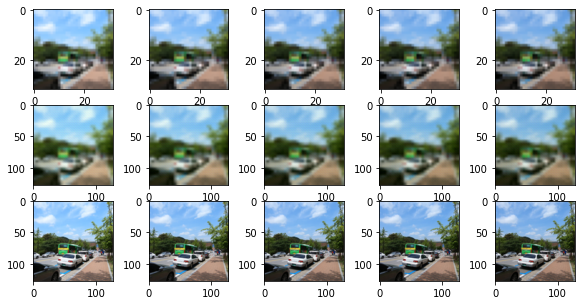

Epoch 9, loss: 0.04794: 100%|██████████| 120/120 [02:36<00:00,  1.30s/it]


<Figure size 432x288 with 0 Axes>

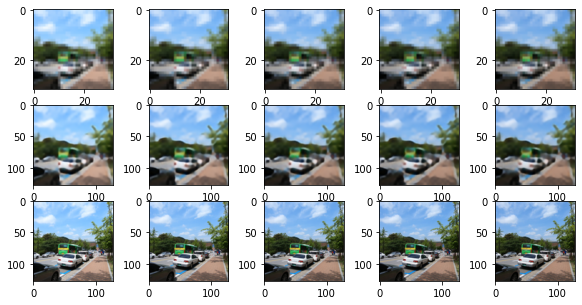

Epoch 9, loss: 0.03907: 100%|██████████| 120/120 [02:36<00:00,  1.30s/it]


<Figure size 432x288 with 0 Axes>

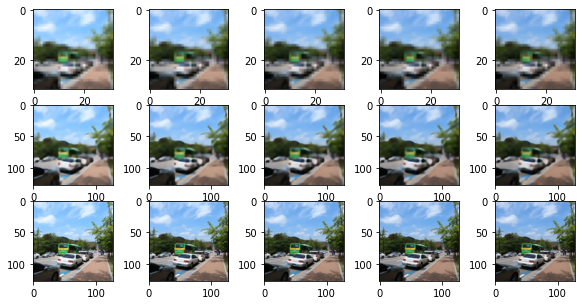

Epoch 9, loss: 0.03812: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it]


<Figure size 432x288 with 0 Axes>

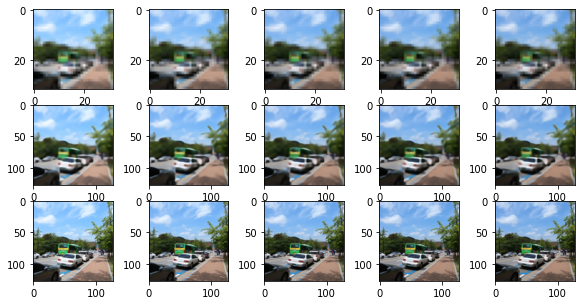

Epoch 9, loss: 0.0354: 100%|██████████| 120/120 [02:36<00:00,  1.31s/it] 


<Figure size 432x288 with 0 Axes>

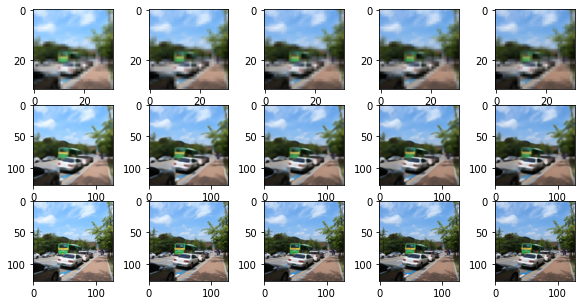

Epoch 9, loss: 0.02801: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it]


<Figure size 432x288 with 0 Axes>

In [11]:
for _ in range(EPOCHS//SHOW_PREDS_EVERY):
    lr, hr = ds[0]
    lr = torch.Tensor(lr/255.) # normalize
    lr = lr.permute(0, 3, 1, 2)[None, :, :, :, :] # THWC -> TCHW -> NTCHW
    
    sr = gen(lr.to(device)) # predict
    sr = sr.cpu().detach().numpy() # convert to np array
    lr = lr.numpy()[0].transpose(0, 2, 3, 1) # NTCHW -> TCHW -> THWC
    sr = sr[0].transpose(0, 2, 3, 1) # NTCHW -> TCHW -> THWC
    fig, ax = plt.subplots(3, 5, figsize=(10, 5))
    for i in range(5):
        ax[0][i].imshow(lr[i])
        ax[1][i].imshow(sr[i])
        ax[2][i].imshow(hr[i])
    plt.show()
    plt.clf() # clear figure
    train(gen, dataloader, opt, epochs=SHOW_PREDS_EVERY)

### Visualize Results

torch.Size([1, 15, 3, 32, 32])
LR shape: (15, 32, 32, 3) | HR Shape: (15, 128, 128, 3)


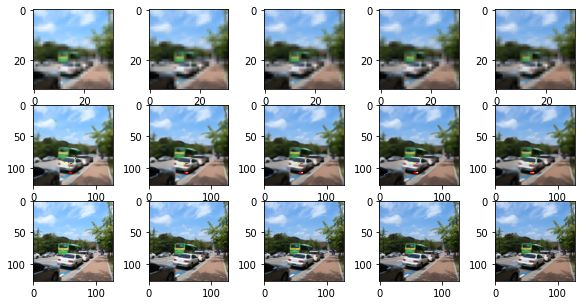

In [12]:
lr, hr = ds[0]
print(torch.Tensor(lr).permute(0, 3, 1, 2)[None, :, :, :, :].shape)
sr = (gen(torch.Tensor(lr/255.).permute(0, 3, 1, 2)[None, :, :, :, :].to(device)).cpu().detach().numpy()[0].transpose(0, 2, 3, 1) * 255).astype(np.uint8)
print(f'LR shape: {lr.shape} | HR Shape: {hr.shape}')
fig, ax = plt.subplots(3, 5, figsize=(10, 5))
for i in range(5):
    ax[0][i].imshow(lr[i])
    ax[1][i].imshow(sr[i])
    ax[2][i].imshow(hr[i])
plt.show()

### Future Work
Obviously including validation data would be helpful to see if this model generalizes, but in my past experiences, super-resolution networks tend to generalize well to unseen data since it operates on low-level features (e.g. edges, corners, etc.) rather than high-level features (e.g. objects), and since low-level features are plentiful in the input images, the model can work reasonably well on other images that may have different high-level features than in the dataset, but the same low-level features.

Also, using GANs has proven to be successful in super-resolution tasks (see https://arxiv.org/abs/1609.04802v5), so that could make output video look more realistic.

Finally, even though the model can upsample any input video 4x, it would be beneficial to train videos with higher resolution since larger videos contain more features which can lead to improved output quality. 